# Análise do Dataset Scielo

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import os
from multiprocessing import Pool

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from funcoes import limpa_html
from nlp_funcoes import token_lemma, add_bigram, create_dictionary, create_corpus, ModelLDA, calc_coherence

## Leitura do dataset

In [3]:
# muda o diretório atual para a pasta code onde temos o dataset salvo
os.chdir("../code")
os.getcwd()

'D:\\OneDrive\\monografia\\code'

In [4]:
df = pd.read_feather('scielo_dataset.feather')

In [5]:
df = df.query('ano > 2014')

## Limpeza do dataset

In [6]:
with Pool() as pool:
    textos = list(tqdm(pool.imap(limpa_html, df['text_html']), total=len(df)))

  0%|          | 0/810 [00:00<?, ?it/s]

## Análise dos Dados

### Tokenize and Lemma

In [7]:
with Pool() as pool:
    documentos = list(tqdm(pool.imap(token_lemma, textos), total=len(textos)))

  0%|          | 0/810 [00:00<?, ?it/s]

### Bigram, dicionário e corpus

In [8]:
add_bigram(documentos, min_count=5)
dicionario = create_dictionary(documentos, no_below=20, no_above=0.6)
corpus = create_corpus(dicionario, documentos)

### Modelo LDA

In [9]:
temp = dicionario[0]
id2word = dicionario.id2token

In [10]:
lda = ModelLDA(corpus, id2word)

### GridSearch no número de tópicos

In [11]:
n_topicos = list(range(6, 21))
with Pool(processes=9) as pool:
    modelos = list(tqdm(pool.imap_unordered(lda.run, n_topicos), total=len(n_topicos)))

  0%|          | 0/15 [00:00<?, ?it/s]

In [12]:
coerencias = {'u_mass': [],
              'c_v': [],
              'c_uci': [],
              'c_npmi': []}

for modelo in tqdm(modelos):
    for coe in tqdm(coerencias.keys(), leave=False):
        coerencias[coe].append(calc_coherence(modelo, documentos, dicionario, corpus, coe))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

### Gráfico das coerências

In [26]:
def plot_coerencias(coerencias):
    fig, ax = plt.subplots(nrows=1, ncols=len(coerencias),
                           figsize=(5*len(coerencias), 5))
    for i, k in enumerate(coerencias):
        y = coerencias[k]

        ax[i].set_title(k)
        ax[i].set_xlabel('Número de tópicos')

        ax[i].scatter(n_topicos, y, s=12, c='black')
        ax[i].plot(n_topicos, y, c='black')

    fig.tight_layout()
    plt.show()

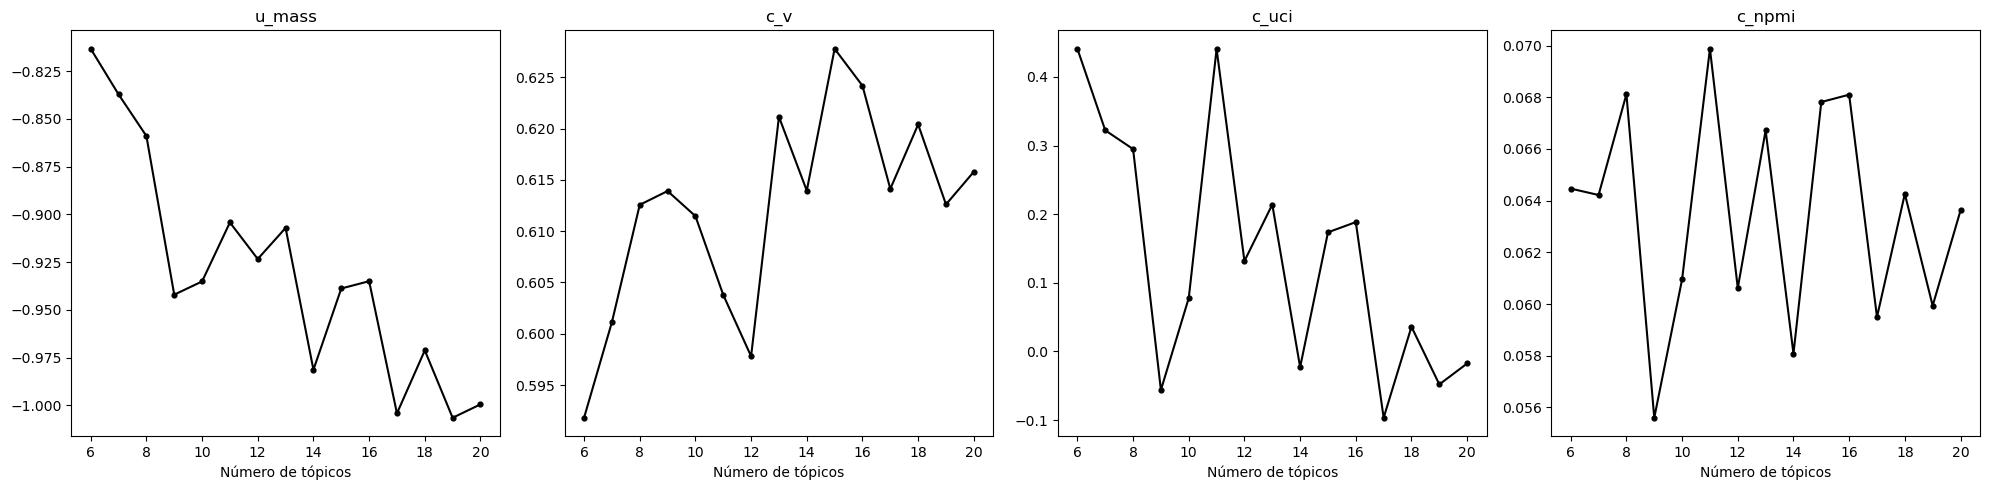

In [27]:
plot_coerencias(coerencias)

### Normalização das coerências 

In [28]:
norm_coerencias = {}
for k, v in coerencias.items():
    x = np.array(v)
    norm_coerencias[k] = (x - min(x)) / (max(x) - min(x))

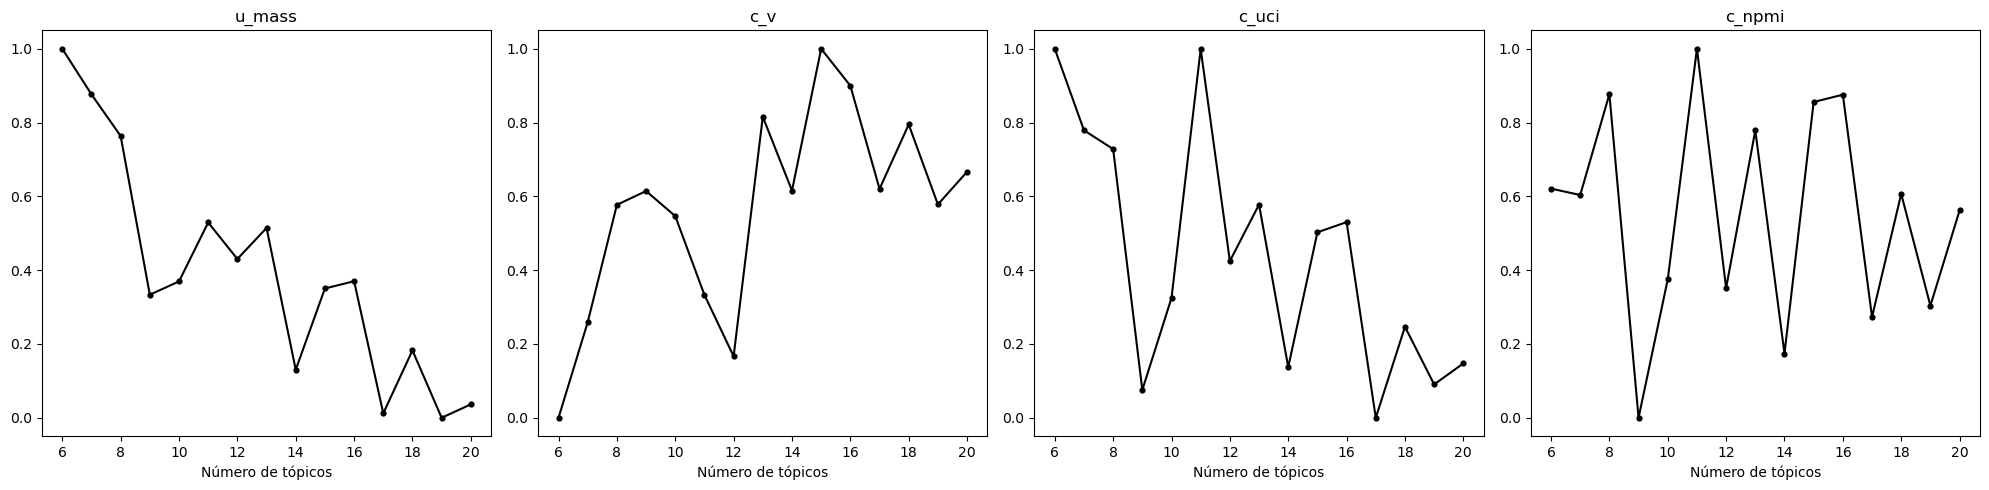

In [29]:
plot_coerencias(norm_coerencias)

In [30]:
medias = sum(norm_coerencias.values()) / len(norm_coerencias)
for i in medias.argsort()[::-1]:
    print(f'Número de tópicos: {str(n_topicos[i]).rjust(2, "0")} | {medias[i]:.3f}')

Número de tópicos: 08 | 0.737
Número de tópicos: 11 | 0.715
Número de tópicos: 15 | 0.677
Número de tópicos: 13 | 0.672
Número de tópicos: 16 | 0.669
Número de tópicos: 06 | 0.655
Número de tópicos: 07 | 0.630
Número de tópicos: 18 | 0.458
Número de tópicos: 10 | 0.404
Número de tópicos: 20 | 0.353
Número de tópicos: 12 | 0.343
Número de tópicos: 14 | 0.264
Número de tópicos: 09 | 0.256
Número de tópicos: 19 | 0.243
Número de tópicos: 17 | 0.226


## Número de tópicos = 8

In [24]:
model = modelos[8 - n_topicos[0]]

In [25]:
model.print_topics()

[(0,
  '0.016*"partícula" + 0.012*"quântico" + 0.010*"luz" + 0.008*"massa" + 0.007*"matéria" + 0.007*"gravitacional" + 0.007*"einstein" + 0.006*"negro" + 0.006*"buraco" + 0.006*"princípio"'),
 (1,
  '0.012*"estudante" + 0.011*"aluno" + 0.011*"ciência" + 0.010*"professor" + 0.010*"conhecimento" + 0.010*"científico" + 0.008*"aula" + 0.007*"atividade" + 0.007*"pesquisa" + 0.007*"conteúdo"'),
 (2,
  '0.018*"luz" + 0.013*"onda" + 0.011*"elétrico" + 0.011*"frequência" + 0.010*"magnético" + 0.009*"experimento" + 0.007*"tensão" + 0.006*"comprimento" + 0.006*"intensidade" + 0.005*"cor"'),
 (3,
  '0.030*"velocidade" + 0.028*"força" + 0.016*"massa" + 0.013*"corpo" + 0.008*"aceleração" + 0.006*"partícula" + 0.006*"pêndulo" + 0.006*"atrito" + 0.005*"distância" + 0.005*"colisão"'),
 (4,
  '0.012*"solução" + 0.009*"potencial" + 0.008*"operador" + 0.008*"espaço" + 0.006*"matriz" + 0.006*"partícula" + 0.006*"vetor" + 0.005*"fase" + 0.005*"quântico" + 0.005*"distribuição"'),
 (5,
  '0.024*"temperatura" 